# Demo: `LatencyAwareLOBEnv` (Projet 2)

Ce notebook vérifie rapidement que l'environnement fonctionne :
- Import depuis le projet (en ajoutant le dossier parent au `sys.path` si besoin)
- Création d'un **FakeLOB** de test (pas besoin du Projet 1 pour ce test)
- Rollout de quelques pas avec `RandomAgent`
- Visualisation de l'observation


In [1]:
import os, sys
# Si tu lances depuis notebooks/, on ajoute le dossier parent pour importer le package du projet
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import numpy as np
from lob_env import LatencyAwareLOBEnv
from agents.random_agent import RandomAgent

print("Parent dir added to sys.path:", parent_dir in sys.path)


Parent dir added to sys.path: True


In [2]:
class FakeLOB:
    """
    LOB factice pour démo : mid fixe, état zéro, jamais 'done'.
    """
    def __init__(self, depth=10):
        self.depth = depth
        self.done = False
        self._mid = 100.0

    def reset(self):
        self.done = False
        self._mid = 100.0

    def step(self):
        pass  # petite dynamique possible plus tard

    def get_state(self):
        import numpy as _np
        return _np.zeros(2 * self.depth, dtype=_np.float32)

    def get_mid_price(self):
        return self._mid


In [3]:
# Création de l'environnement avec features enrichies et normalisation
env = LatencyAwareLOBEnv(
    depth=10,
    external_lob=FakeLOB(depth=10),  # <-- évite la dépendance au Projet 1
    latency_ticks=5,
    latency_jitter=2,
    fee_rate=1e-4,
    slippage_bps=1.0,
    trade_size=1.0,
    include_features=("lob", "mid", "inventory", "cash", "queue_len"),
    normalize=True,
    cash_scale=1e5,
    inventory_scale=100.0,
    mid_scale=1e3,
    queue_scale=100.0,
    lob_scale=1e3,
)

reset_out = env.reset(seed=42)
obs = reset_out[0] if isinstance(reset_out, tuple) else reset_out

print("Observation shape:", obs.shape)
print("Premiers éléments:", obs[:10])


Observation shape: (24,)
Premiers éléments: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
# Lancer un agent aléatoire pour quelques steps
agent = RandomAgent(env.action_space)

for t in range(10):
    action = agent.act(obs)
    step_out = env.step(action)

    if len(step_out) == 5:  # gymnasium
        obs, reward, terminated, truncated, info = step_out
        done = terminated or truncated
    else:  # gym classique
        obs, reward, done, info = step_out

    print(f"Step {t:02d} | Action={action} | Reward={reward:.6f} | Equity={info['equity']:.2f} | Queue={info['queue_len']}")
    if done:
        break


Step 00 | Action=2 | Reward=0.000000 | Equity=0.00 | Queue=1
Step 01 | Action=2 | Reward=0.000000 | Equity=0.00 | Queue=2
Step 02 | Action=1 | Reward=-0.019999 | Equity=-0.02 | Queue=2
Step 03 | Action=1 | Reward=0.000000 | Equity=-0.02 | Queue=3
Step 04 | Action=2 | Reward=0.000000 | Equity=-0.02 | Queue=4
Step 05 | Action=0 | Reward=0.000000 | Equity=-0.02 | Queue=4
Step 06 | Action=2 | Reward=-0.019999 | Equity=-0.04 | Queue=4
Step 07 | Action=0 | Reward=-0.040002 | Equity=-0.08 | Queue=2
Step 08 | Action=2 | Reward=-0.019999 | Equity=-0.10 | Queue=2
Step 09 | Action=0 | Reward=0.000000 | Equity=-0.10 | Queue=2


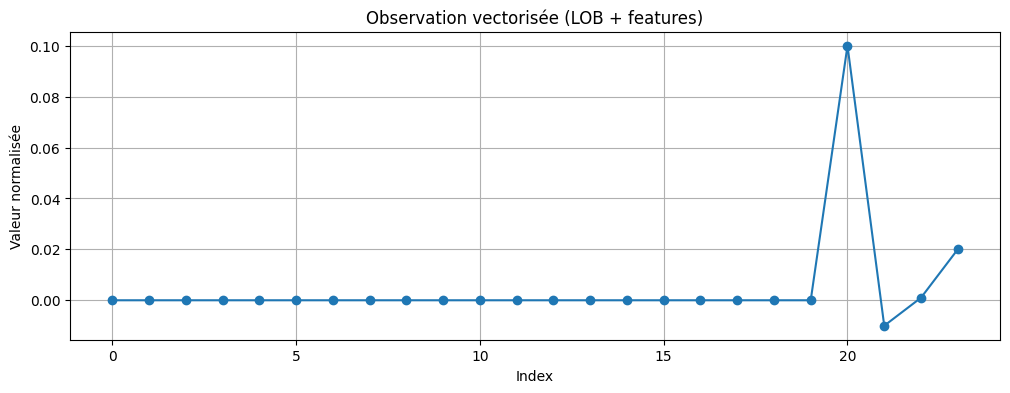

In [5]:
# Visualiser la dernière observation (vectorisée)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(obs, marker='o')
plt.title("Observation vectorisée (LOB + features)")
plt.xlabel("Index")
plt.ylabel("Valeur normalisée")
plt.grid(True)
plt.show()
